## Feature Selection using Ensemble based methods

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score

Below we perform feature selection to identify genes that have high contribution in differentiating different types of cancer using tree-based ensembl methods

In [2]:
blca_df = pd.read_csv("data/BLCA_gene_exp.csv", index_col=0)
cesc_df = pd.read_csv("data/CESC_gene_exp.csv", index_col=0)
kirc_df = pd.read_csv("data/KIRC_gene_exp.csv", index_col=0)
hnsc_df = pd.read_csv("data/HNSC_gene_exp.csv", index_col=0)
lgg_df = pd.read_csv("data/LGG_gene_exp.csv", index_col=0)
gbm_df = pd.read_csv("data/GBM_gene_exp.csv", index_col=0)

In [3]:
df_list = [blca_df, cesc_df, kirc_df, hnsc_df, lgg_df, gbm_df]
cancer_type = ['BLCA', 'CESC', 'KIRC', 'HNSC', 'LGG', 'GBM']

for df, c_type in zip(df_list, cancer_type):
    df['cancer_type'] = c_type
    print(f' Shape: {df.shape}')

 Shape: (426, 20531)
 Shape: (307, 20531)
 Shape: (606, 20531)
 Shape: (566, 20531)
 Shape: (529, 20531)
 Shape: (518, 12043)


In [6]:
#find intersecting genes
common_genes = set(df_list[0].columns)
for df in df_list[1:]:
    common_genes &= set(df.columns)

#merge data on common genes
dfs_filtered = [df[list(common_genes)] for df in df_list]
merged_df = pd.concat(dfs_filtered, axis=0)

print(f"Merged Data Shape: {merged_df.shape}")
print(merged_df.head())

Merged Data Shape: (2952, 11313)
                    MNAT1    MCOLN3     AP1G2    SPATA2     MYO1B     PRRG3  \
TCGA-DK-A6B5-01 -1.182032 -0.475046 -0.632061  1.773312  1.127217 -0.181968   
TCGA-5N-A9KM-01  2.662895 -0.284390 -0.402161 -0.012131 -0.478424 -0.372348   
TCGA-BT-A0S7-01  0.438589 -0.320588 -0.972642 -0.978107  0.691265  0.700569   
TCGA-FD-A43Y-01 -1.077121  0.919596 -0.378000 -0.387792  0.810300 -0.372348   
TCGA-YF-AA3L-01  0.047859 -0.497156  0.903700  0.771299 -0.803956 -0.372348   

                    IFI16   SLC11A1      SELT   POLDIP2  ...      ATRN  \
TCGA-DK-A6B5-01  1.401482  0.084248  1.101553 -0.070794  ...  1.300695   
TCGA-5N-A9KM-01 -0.604788  0.212734  2.345916  0.128220  ...  0.246824   
TCGA-BT-A0S7-01 -0.801010 -0.649306 -0.854521  0.621370  ...  6.643765   
TCGA-FD-A43Y-01  1.785375  0.625049  0.185219 -0.092054  ...  3.400981   
TCGA-YF-AA3L-01 -0.413634 -0.641221 -0.785221  2.022527  ... -0.369662   

                    PARP1      FHL2       LCK  

### Using Random Forest

In [9]:
#obtain features and labels from merged dataset
X = merged_df.loc[:, merged_df.columns != "cancer_type"]
y = merged_df["cancer_type"]

#select top 2000  variable genes
gene_variance = X.var(axis=0)
hv_genes = gene_variance.nlargest(5000).index
X_selected = X[hv_genes]

#rebalance class labels using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

In [10]:
#train/test split - 80:20
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [11]:
#fit random forest model
rf_model = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=500, random_state=42)

In [12]:
#evaluation
y_pred_rf = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Accuracy: 1.0
              precision    recall  f1-score   support

        BLCA       1.00      1.00      1.00       121
        CESC       1.00      1.00      1.00       121
         GBM       1.00      1.00      1.00       121
        HNSC       1.00      1.00      1.00       122
        KIRC       1.00      1.00      1.00       122
         LGG       1.00      1.00      1.00       121

    accuracy                           1.00       728
   macro avg       1.00      1.00      1.00       728
weighted avg       1.00      1.00      1.00       728



/tmp/ipykernel_3461043/3236013627.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values[:top_n], y=feat_imp.index[:top_n], palette="viridis")


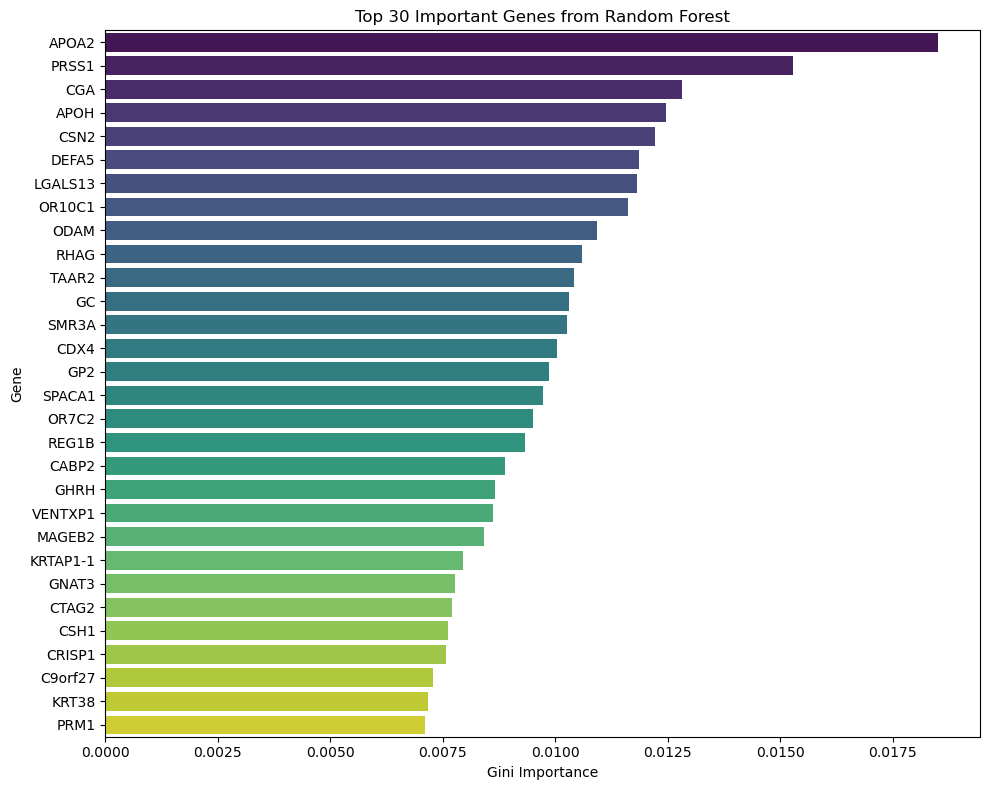

In [17]:
#finding feature importance using gini importance and plotting
importances = rf_model.feature_importances_
feature_names = X_selected.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

#plotting top 30 important genes
top_n = 30
plt.figure(figsize=(10, 8))
sns.barplot(x=feat_imp.values[:top_n], y=feat_imp.index[:top_n], palette="viridis")
plt.title(f"Top {top_n} Important Genes from Random Forest")
plt.xlabel("Gini Importance")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()

We tried using different combination of hyperparameters and values, but the model was overfitting. This could be becuase of very high number of features used. We note that using unsupervised dimensionality reduction techniques like PCA or tSNE will move the features to Z-space and we won't be able to recover the original features later to for selecting important featues.

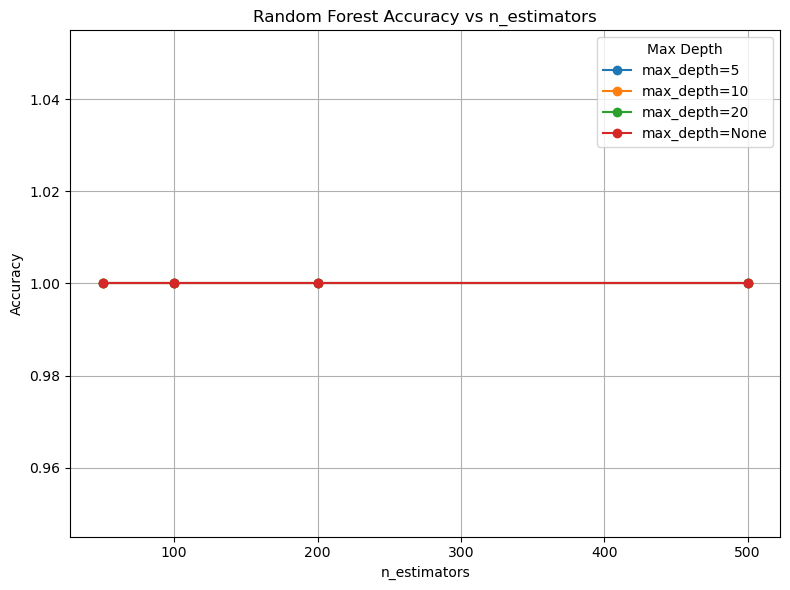

In [23]:
#plotting accuracy for different values of hyperparameters
n_estimators_range = [50, 100, 200, 500]
max_depth_range = [5, 10, 20, None]

rf_results = []

for n in n_estimators_range:
    for d in max_depth_range:
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        rf_results.append({ "n_estimators": n, "max_depth": str(d) if d else "None", "Accuracy": acc})

rf_df = pd.DataFrame(rf_results)

plt.figure(figsize=(8, 6))
for d in rf_df["max_depth"].unique():
    subset = rf_df[rf_df["max_depth"] == d]
    plt.plot(subset["n_estimators"], subset["Accuracy"], marker="o", label=f"max_depth={d}")

plt.title("Random Forest Accuracy vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend(title="Max Depth")
plt.grid(True)
plt.tight_layout()
plt.show()

We see overlapping line at accuracy 1.0 for different values of n_estimators and max_depth

### Using ExtraTree Classifier

In [14]:
#fitting the model
et_model = ExtraTreesClassifier(n_estimators=300, max_depth=5, min_samples_split=50, random_state=42)
et_model.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=5, min_samples_split=50, n_estimators=300,
                     random_state=42)

In [15]:
#evaluation
y_pred_et = et_model.predict(X_test)
print("ExtraTrees Accuracy:", accuracy_score(y_test, y_pred_et))
print(classification_report(y_test, y_pred_et))

ExtraTrees Accuracy: 1.0
              precision    recall  f1-score   support

        BLCA       1.00      1.00      1.00       121
        CESC       1.00      1.00      1.00       121
         GBM       1.00      1.00      1.00       121
        HNSC       1.00      1.00      1.00       122
        KIRC       1.00      1.00      1.00       122
         LGG       1.00      1.00      1.00       121

    accuracy                           1.00       728
   macro avg       1.00      1.00      1.00       728
weighted avg       1.00      1.00      1.00       728



/tmp/ipykernel_3461043/513404913.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values[:top_n], y=feat_imp.index[:top_n], palette="viridis")


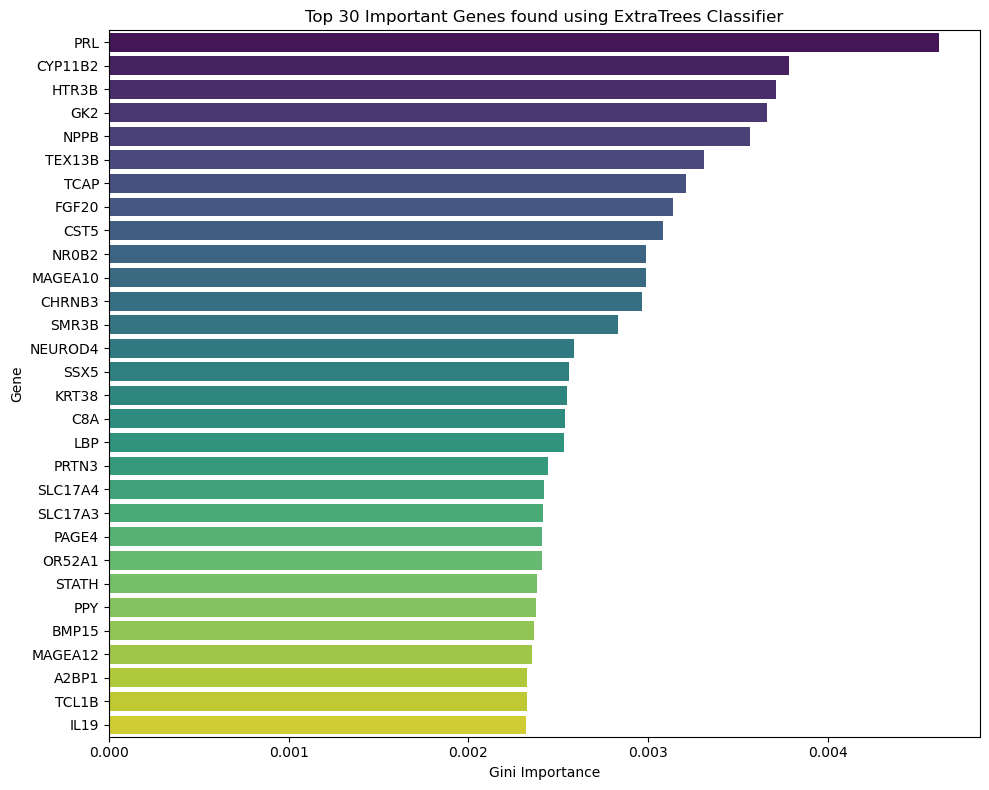

In [18]:
#finding feature importance using gini importance and plotting
importances = et_model.feature_importances_
feature_names = X_selected.columns  # Use original gene names
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

#plotting top 30 important genes
top_n = 30
plt.figure(figsize=(10, 8))
sns.barplot(x=feat_imp.values[:top_n], y=feat_imp.index[:top_n], palette="viridis")
plt.title(f"Top {top_n} Important Genes found using ExtraTrees Classifier")
plt.xlabel("Gini Importance")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()

Similar to Random Forest, Extra Trees Classifier was also overfitting the data even with different combinations of hyperparameter values.

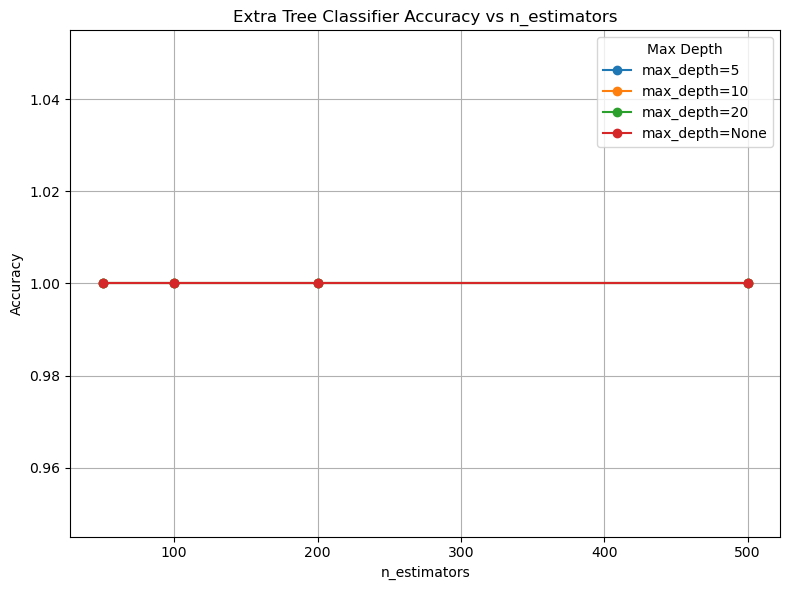

In [24]:
#plotting accuracy for different values of hyperparameters
n_estimators_range = [50, 100, 200, 500]
max_depth_range = [5, 10, 20, None]

et_results = []

for n in n_estimators_range:
    for d in max_depth_range:
        et = ExtraTreesClassifier(n_estimators=n, max_depth=d, random_state=42)
        et.fit(X_train, y_train)
        et_pred = et.predict(X_test)
        et_acc = accuracy_score(y_test, et_pred)
        et_results.append({ "n_estimators": n, "max_depth": str(d) if d else "None", "Accuracy": acc})

et_df = pd.DataFrame(et_results)

plt.figure(figsize=(8, 6))
for d in et_df["max_depth"].unique():
    subset = et_df[et_df["max_depth"] == d]
    plt.plot(subset["n_estimators"], subset["Accuracy"], marker="o", label=f"max_depth={d}")

plt.title("Extra Tree Classifier Accuracy vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend(title="Max Depth")
plt.grid(True)
plt.tight_layout()
plt.show()

We see overlapping line at accuracy 1.0 for different values of n_estimators and max_depth